In [1]:
!pip install imblearn

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install -U sagemaker

Requirement already up-to-date: sagemaker in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (2.16.3.post0)
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
import boto3
import os
import pandas as pd
import numpy as np

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import sagemaker
from sagemaker import get_execution_role
from sagemaker import image_uris
from sagemaker.predictor import csv_serializer
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

In [4]:
session = sagemaker.Session()
bucket = session.default_bucket()

# from sagemaker import get_execution_role
germany_data_key = 'udacity-capstone/data/Udacity_AZDIAS_052018.csv'
data_location = 's3://{}/{}'.format(bucket, germany_data_key)

germany_df = pd.read_csv(data_location, sep=';')
germany_df.shape

(891221, 366)

In [5]:
train_data_key = 'udacity-capstone/data/Udacity_MAILOUT_052018_TRAIN.csv'
train_location = 's3://{}/{}'.format(bucket, train_data_key)
train_df = pd.read_csv(train_location, sep=';')
print(train_df.shape)


test_data_key = 'udacity-capstone/data/Udacity_MAILOUT_052018_TEST.csv'
test_location = 's3://{}/{}'.format(bucket, test_data_key)
test_df = pd.read_csv(test_location, sep=';')
print(test_df.shape)


metadata_data_key = 'udacity-capstone/data/metadata.csv'
metadata_location = 's3://{}/{}'.format(bucket, metadata_data_key)
metadata = pd.read_csv(metadata_location)
print(metadata.shape)

(42962, 367)
(42833, 366)
(312, 8)


In [6]:
train_data = train_df.set_index('LNR', verify_integrity=True)
train_y = train_data['RESPONSE']
print(train_y.head())

test_data = test_df.set_index('LNR', verify_integrity=True)
test_data.head()

LNR
1763    0
1771    0
1776    0
1460    0
1783    0
Name: RESPONSE, dtype: int64


,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,0.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,0.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,0.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,0.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [7]:
def reverse_order(val, mx, mn):
    diff_from_low = val - mn
    return mx - diff_from_low


def clean_data(df, metadata, drop_threshold=20, testing=False):
    # keep features that exist in the metadata file
    keep_features = list(metadata[metadata['keep'] == 1]['feature_name'])

    df = df[keep_features]
    
    # drop special cases
    if not testing:
        df = df[df['CAMEO_DEUG_2015'] != 'X']
        df = df[df['CAMEO_DEU_2015'] != 'XX']
    else:
        df.loc[df['CAMEO_DEUG_2015'] == 'X'] = -1
        df.loc[df['CAMEO_DEU_2015'] == 'XX'] = '5C'
    
    # set zero to negative one where zero means unknown
    unknown_zero_features = list(metadata[metadata['unknown_zero'] == 1]['feature_name'])
    for feature in unknown_zero_features:
        df.loc[df[feature] == 0, feature] = -1
        
    # set nine to negative one where nine means unknown
    unknown_nine_features = list(metadata[metadata['unknown_nine'] == 1]['feature_name'])
    for feature in unknown_nine_features:
        df.loc[df[feature] == 9, feature] = -1
        
    # set -1 (unknown) to np.nan
    df = df.replace(-1, np.nan)
    
    # one hot encode categorical variables
    one_hot_cols = list(metadata.loc[(metadata['type'] == 'categorical') & (metadata['keep'] == 1), 'feature_name'])            
    df = pd.get_dummies(df, prefix=one_hot_cols, columns=one_hot_cols)
    
    
    # drop features with percentage of missing columns > drop_threshold
    percent_missing = df.isnull().sum() * 100 / len(df)
    mv_df = pd.DataFrame({'column_name': df.columns, 'percent_missing': percent_missing})
    mv_cols = mv_df.loc[mv_df['percent_missing'] > drop_threshold]['column_name']    
    df = df.drop(list(mv_cols), axis=1)
    
    # drop na
    if not testing:
        df = df.dropna()
    else:
        df = df.fillna(0)
    
    # set all to float
    df = df.astype('float32')
    
    if False:
        # reverse some columns so they make more intuitive sense
        reverse_cols = list(metadata.loc[metadata['needs_reverse'] == 1, 'feature_name'])
        df_cols = list(df.columns)
        for col in reverse_cols:
            if col in df_cols:
                series = df[col]
                df[col] = series.apply(reverse_order, args=(np.max(series), np.min(series)))
    
    return df

In [8]:
clean_g_data = clean_data(germany_df, metadata)
print(clean_g_data.shape)

clean_train_data = clean_data(train_data, metadata, drop_threshold=22)
print(clean_train_data.shape)

clean_test_data = clean_data(test_data, metadata, drop_threshold=22, testing=True)
print(clean_test_data.shape)

(616864, 371)
(31577, 369)
(42833, 369)


In [9]:
g_cols = set(clean_g_data.columns)
train_cols = set(clean_train_data.columns)
test_cols = set(clean_test_data.columns)

intersection = set.intersection(g_cols, train_cols, test_cols)

clean_g_data = clean_g_data[list(intersection)]
clean_train_data = clean_train_data[list(intersection)]
clean_test_data = clean_test_data[list(intersection)]

assert(sorted(list(clean_g_data.columns)) == sorted(list(clean_train_data.columns)) == sorted(list(clean_test_data.columns)))

print(clean_g_data.shape)
print(clean_train_data.shape)
print(clean_test_data.shape)

(616864, 356)
(31577, 356)
(42833, 356)


In [10]:
clean_g_data.iloc[0:5, 0:6]

,ORTSGR_KLS9,KBA13_VORB_1,SEMIO_VERT,KONSUMNAEHE_4.0,ANZ_PERSONEN,VERS_TYP_1.0
1,5.0,3.0,1.0,0.0,2.0,0.0
2,5.0,4.0,4.0,0.0,1.0,1.0
4,6.0,2.0,7.0,1.0,4.0,0.0
5,3.0,3.0,2.0,0.0,1.0,0.0
6,6.0,4.0,2.0,0.0,1.0,1.0


In [11]:
string_df = clean_g_data.select_dtypes(exclude=[np.number])
string_df.columns

Index([], dtype='object')

In [12]:
scaler = MinMaxScaler()
germany_scaled_df = pd.DataFrame(scaler.fit_transform(clean_g_data.astype(float)))
print(germany_scaled_df.shape)

train_scaled_df = pd.DataFrame(scaler.fit_transform(clean_train_data.astype(float)))
print(train_scaled_df.shape)

test_scaled_df = pd.DataFrame(scaler.fit_transform(clean_test_data.astype(float)))
print(test_scaled_df.shape)

(616864, 356)
(31577, 356)
(42833, 356)


In [67]:
NUM_COMPONENTS = 152
pca = PCA(n_components=NUM_COMPONENTS)
pca.fit(germany_scaled_df)
print(np.sum(pca.explained_variance_ratio_))

0.9964305655020406


In [68]:
np.sum(pca.explained_variance_ratio_[:300])

0.9964305655020406

In [69]:
features_list = list(clean_g_data.columns)
len(features_list)

356

In [70]:
feature_weights = pca.components_
w_df = pd.DataFrame(feature_weights, columns=clean_g_data.columns)
w_df.tail()

,ORTSGR_KLS9,KBA13_VORB_1,SEMIO_VERT,KONSUMNAEHE_4.0,ANZ_PERSONEN,VERS_TYP_1.0,GFK_URLAUBERTYP_6.0,KBA13_KW_0_60,KBA05_CCM1,KBA13_SEG_VAN,...,D19_VERSAND_ANZ_12,KONSUMNAEHE_1.0,LP_FAMILIE_GROB,KBA13_CCM_3001,CAMEO_DEU_2015_1C,KONSUMNAEHE_6.0,KBA13_SEG_KLEINST,KBA05_HERST3,WOHNDAUER_2008,KBA13_HALTER_45
295,0.018351,-0.068766,-0.003450,-0.000996,-0.000507,-0.000361,-0.001327,0.041266,-0.008946,-0.004097,...,0.005060,-0.003109,-0.000815,0.001702,0.631143,0.005909,0.035880,0.000419,-0.000359,-0.001331
296,0.005223,0.034621,-0.000115,0.002639,0.000398,0.000006,0.000239,-0.016143,-0.005700,0.019110,...,-0.003584,0.002352,-0.000855,0.001360,0.070667,0.002348,0.662101,-0.002466,-0.000321,-0.001568
297,0.006747,0.015174,0.002546,0.000419,0.000217,-0.000020,0.000964,-0.026774,-0.011890,0.011722,...,-0.007458,0.002411,-0.000410,0.000410,-0.260892,0.002245,0.139724,-0.005827,0.000614,-0.000195
298,-0.019835,0.006696,-0.000124,-0.000584,0.000129,0.000193,-0.000038,-0.075828,-0.004572,-0.008148,...,0.008192,-0.000972,0.000341,-0.000324,0.106826,-0.000926,-0.121213,-0.023977,0.000507,-0.002594
299,-0.005157,0.010003,0.001609,-0.001261,0.000207,0.000044,-0.000202,-0.037098,-0.001235,-0.002376,...,-0.000016,-0.000937,0.001199,-0.000643,-0.489197,0.000899,0.057682,-0.000231,-0.000374,0.001035


In [71]:
def display_component(v, features_list, component_num, n_weights=10):
    v_1_row = v.iloc[component_num, :]
    v_1 = np.squeeze(v_1_row.values)
    weights = pd.DataFrame(list(zip(v_1, features_list)), columns=['weight', 'feature'])
    weights['abs_weight'] = weights['weight'].apply(lambda x: np.abs(x))
    sorted_weight_data = weights.sort_values('abs_weight', ascending=False).head(n_weights)
    ax = plt.subplots(figsize=(9,7))
    ax = sns.barplot(data=sorted_weight_data, x='weight', y='feature', palette='Blues_d')
    ax.set_title(f'PCA Component Makeup for Component #{component_num}')
    plt.show()

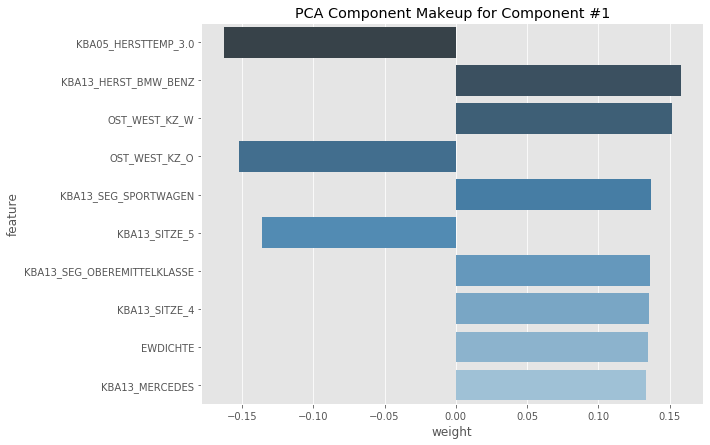

In [72]:
num = 1
display_component(w_df, features_list, num, n_weights=10)

In [73]:
# transform germany and customer data
germany_pca_data = pca.transform(germany_scaled_df)
germany_pca_data.shape

(616864, 300)

In [74]:
train_pca_data = pca.transform(train_scaled_df)
train_pca_data.shape

(31577, 300)

In [75]:
test_pca_data = pca.transform(test_scaled_df)
test_pca_data.shape

(42833, 300)

In [22]:
k = 2
kmeans = KMeans(n_clusters=k)
kmeans.fit(germany_pca_data)

KMeans(n_clusters=2)

In [23]:
germany_pred = kmeans.predict(germany_pca_data)
train_pred = kmeans.predict(train_pca_data)
test_pred = kmeans.predict(test_pca_data)

In [24]:
germany_pred_df = pd.DataFrame(germany_pred)
germany_values = germany_pred_df[0].value_counts().sort_index()
train_pred_df = pd.DataFrame(train_pred)
train_values = train_pred_df[0].value_counts().sort_index()
test_pred_df = pd.DataFrame(test_pred)
test_values = test_pred_df[0].value_counts().sort_index()

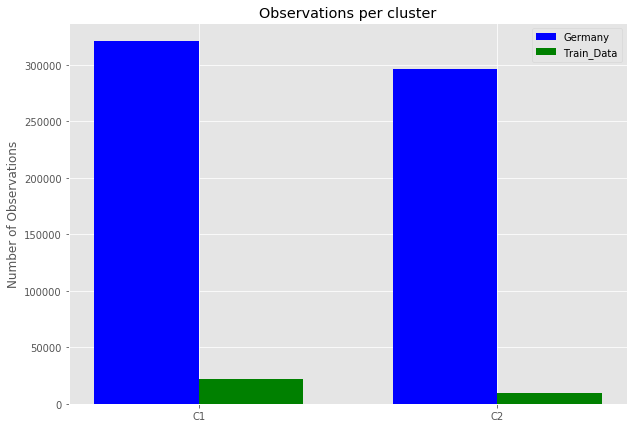

In [25]:
x = np.arange(k)  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 7))
rects1 = ax.bar(x - width/2, germany_values.values, width, label='Germany', color='blue')
rects2 = ax.bar(x + width/2, train_values.values, width, label='Train_Data', color='green')

# Add some text for labels, title and custom x-axis tick labels, etc.
labels = ['C{}'.format(ix + 1) for ix in np.arange(k)]
ax.set_ylabel('Number of Observations')
ax.set_title('Observations per cluster')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

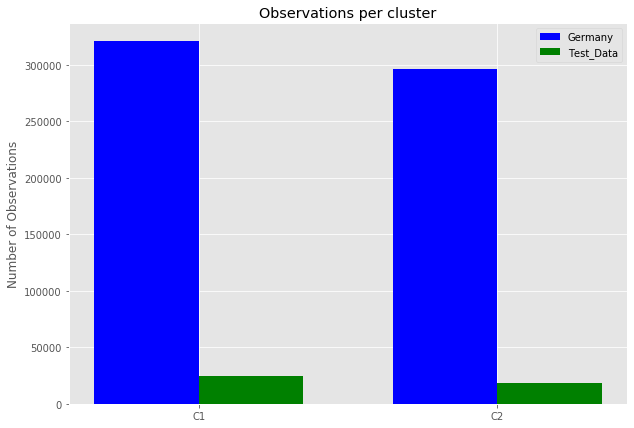

In [26]:
x = np.arange(k)  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 7))
rects1 = ax.bar(x - width/2, germany_values.values, width, label='Germany', color='blue')
rects2 = ax.bar(x + width/2, test_values.values, width, label='Test_Data', color='green')

# Add some text for labels, title and custom x-axis tick labels, etc.
labels = ['C{}'.format(ix + 1) for ix in np.arange(k)]
ax.set_ylabel('Number of Observations')
ax.set_title('Observations per cluster')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

In [27]:
kmeans_df = pd.DataFrame(kmeans.cluster_centers_, columns = ['comp_{}'.format(i) for i in range(1,153)])
kmeans_df

,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,comp_9,comp_10,...,comp_143,comp_144,comp_145,comp_146,comp_147,comp_148,comp_149,comp_150,comp_151,comp_152
0,-1.177684,-0.146617,0.010151,-0.051985,0.035886,0.007244,-0.027176,0.005368,-0.007426,-0.017436,...,0.000915,0.000638,-0.000693,0.001234,0.001394,0.000433,0.000918,-0.000981,0.001018,0.003489
1,1.273736,0.158575,-0.010979,0.056225,-0.038813,-0.007835,0.029392,-0.005806,0.008032,0.018858,...,-0.000989,-0.000690,0.000749,-0.001334,-0.001508,-0.000468,-0.000993,0.001061,-0.001102,-0.003773


Text(0.5, 1, 'Cluster Makeup')

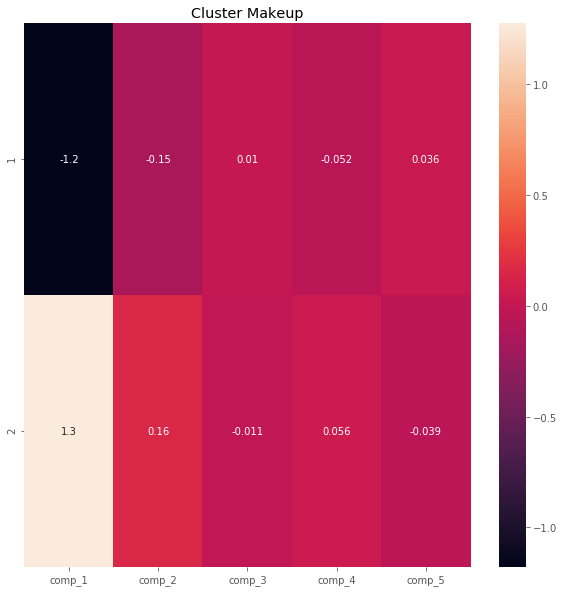

In [28]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(kmeans_df.iloc[0:13, 0:5], annot=True)
#sns.heatmap(kmeans_df, annot=True)
ax.set_yticklabels(np.arange(1,14))
plt.title('Cluster Makeup')

In [29]:
train_pca_df = pd.DataFrame(train_pca_data, columns=['comp_{}'.format(k) for k in range(152)], index=clean_train_data.index)
train_pca_df.head()

,comp_0,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,comp_9,...,comp_142,comp_143,comp_144,comp_145,comp_146,comp_147,comp_148,comp_149,comp_150,comp_151
LNR,,,,,,,,,,,,,,,,,,,,,
1763,1.235954,1.609339,-1.926712,0.783094,-0.743178,-0.021429,-0.057427,0.198967,-0.780992,-0.923590,...,0.075458,-0.253530,0.180353,-0.009351,0.136474,-0.104630,0.213661,-0.235790,0.036990,0.103384
1771,-2.056231,-1.092153,-0.114781,-0.212326,-0.834141,1.114026,0.929972,0.230050,-0.312176,-0.131994,...,-0.151673,-0.149357,-0.039422,-0.148838,0.237747,-0.131102,0.107916,-0.114756,-0.333323,-0.070340
1460,-1.255538,3.139507,-1.899448,0.514190,0.331716,-0.541497,0.288233,-0.718050,0.334448,0.111976,...,0.013569,0.000785,-0.198613,0.128701,-0.217227,-0.147910,0.124439,0.209215,0.129304,-0.051783
1783,-0.270076,1.619769,-0.790068,0.586823,1.229443,0.732465,-0.219228,0.030090,1.042947,0.372656,...,0.166817,0.109024,-0.103470,0.057776,0.043932,0.101819,0.166147,-0.059805,-0.192452,0.153703
1789,1.668911,1.173421,-0.132472,2.249763,-1.671000,1.158704,1.286842,0.663074,0.297877,-0.190828,...,0.505209,0.105157,-0.399250,0.242141,0.171312,-0.296057,-0.202471,0.241148,-0.264764,-0.041274


In [30]:
train_pca_df['cluster'] = train_pred
train_pca_df.head()

,comp_0,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,comp_9,...,comp_143,comp_144,comp_145,comp_146,comp_147,comp_148,comp_149,comp_150,comp_151,cluster
LNR,,,,,,,,,,,,,,,,,,,,,
1763,1.235954,1.609339,-1.926712,0.783094,-0.743178,-0.021429,-0.057427,0.198967,-0.780992,-0.923590,...,-0.253530,0.180353,-0.009351,0.136474,-0.104630,0.213661,-0.235790,0.036990,0.103384,1
1771,-2.056231,-1.092153,-0.114781,-0.212326,-0.834141,1.114026,0.929972,0.230050,-0.312176,-0.131994,...,-0.149357,-0.039422,-0.148838,0.237747,-0.131102,0.107916,-0.114756,-0.333323,-0.070340,0
1460,-1.255538,3.139507,-1.899448,0.514190,0.331716,-0.541497,0.288233,-0.718050,0.334448,0.111976,...,0.000785,-0.198613,0.128701,-0.217227,-0.147910,0.124439,0.209215,0.129304,-0.051783,0
1783,-0.270076,1.619769,-0.790068,0.586823,1.229443,0.732465,-0.219228,0.030090,1.042947,0.372656,...,0.109024,-0.103470,0.057776,0.043932,0.101819,0.166147,-0.059805,-0.192452,0.153703,0
1789,1.668911,1.173421,-0.132472,2.249763,-1.671000,1.158704,1.286842,0.663074,0.297877,-0.190828,...,0.105157,-0.399250,0.242141,0.171312,-0.296057,-0.202471,0.241148,-0.264764,-0.041274,1


In [31]:
mask = train_pca_df.index.intersection(train_y.index)
train_y = train_y.loc[mask]
train_y.shape

(31577,)

In [32]:
train_pca_df.insert(loc=0, column='RESPONSE', value=train_y)

In [33]:
train_pca_df.head()

,RESPONSE,comp_0,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,...,comp_143,comp_144,comp_145,comp_146,comp_147,comp_148,comp_149,comp_150,comp_151,cluster
LNR,,,,,,,,,,,,,,,,,,,,,
1763,0,1.235954,1.609339,-1.926712,0.783094,-0.743178,-0.021429,-0.057427,0.198967,-0.780992,...,-0.253530,0.180353,-0.009351,0.136474,-0.104630,0.213661,-0.235790,0.036990,0.103384,1
1771,0,-2.056231,-1.092153,-0.114781,-0.212326,-0.834141,1.114026,0.929972,0.230050,-0.312176,...,-0.149357,-0.039422,-0.148838,0.237747,-0.131102,0.107916,-0.114756,-0.333323,-0.070340,0
1460,0,-1.255538,3.139507,-1.899448,0.514190,0.331716,-0.541497,0.288233,-0.718050,0.334448,...,0.000785,-0.198613,0.128701,-0.217227,-0.147910,0.124439,0.209215,0.129304,-0.051783,0
1783,0,-0.270076,1.619769,-0.790068,0.586823,1.229443,0.732465,-0.219228,0.030090,1.042947,...,0.109024,-0.103470,0.057776,0.043932,0.101819,0.166147,-0.059805,-0.192452,0.153703,0
1789,0,1.668911,1.173421,-0.132472,2.249763,-1.671000,1.158704,1.286842,0.663074,0.297877,...,0.105157,-0.399250,0.242141,0.171312,-0.296057,-0.202471,0.241148,-0.264764,-0.041274,1


In [35]:
temp_dir = './data'
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

test_pca_df = pd.DataFrame(test_pca_data, columns=['comp_{}'.format(k) for k in range(152)], index=clean_test_data.index)
test_pca_df['cluster'] = test_pred
test_pca_zero = test_pca_df[test_pca_df['cluster'] == 0].drop('cluster', axis=1)
test_pca_zero.to_csv('data/test_data_zero.csv', index=False, header=False)
test_pca_one = test_pca_df[test_pca_df['cluster'] == 1].drop('cluster', axis=1)
test_pca_one.to_csv('data/test_data_one.csv', index=False, header=False)
                                                             
prefix = 'udacity-capstone/training-files/clustered-xgboost/test_data'

official_testing_location_zero = session.upload_data(os.path.join(temp_dir, 'test_data_zero.csv'), key_prefix=prefix)                                                          
official_testing_location_one = session.upload_data(os.path.join(temp_dir, 'test_data_one.csv'), key_prefix=prefix)                                                                                                                       

In [36]:
train_cluster_zero = train_pca_df[train_pca_df['cluster'] == 0]
train_cluster_zero = train_cluster_zero.drop('cluster', axis=1)

train_cluster_one = train_pca_df[train_pca_df['cluster'] == 1]
train_cluster_one = train_cluster_one.drop('cluster', axis=1)

In [37]:
from sklearn.model_selection import train_test_split

y = train_cluster_zero['RESPONSE']
X = train_cluster_zero.drop('RESPONSE', axis=1)
X_train_zero, X_valid_zero, y_train_zero, y_valid_zero = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)


y = train_cluster_one['RESPONSE']
X = train_cluster_one.drop('RESPONSE', axis=1)
X_train_one, X_valid_one, y_train_one, y_valid_one = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [38]:
oversample = SMOTE()
X_train_smote_zero, y_train_smote_zero = oversample.fit_resample(X_train_zero, y_train_zero)
X_train_smote_zero.insert(0, column='RESPONSE', value=y_train_smote_zero)
X_valid_zero.insert(0, column='RESPONSE', value=y_valid_zero)


X_train_smote_one, y_train_smote_one = oversample.fit_resample(X_train_one, y_train_one)
X_train_smote_one.insert(0, column='RESPONSE', value=y_train_smote_one)
X_valid_one.insert(0, column='RESPONSE', value=y_valid_one)
X_train_smote_one.head()



,RESPONSE,comp_0,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,...,comp_142,comp_143,comp_144,comp_145,comp_146,comp_147,comp_148,comp_149,comp_150,comp_151
0,0,0.604405,-0.829730,-1.183806,0.212504,0.449199,-0.671603,-0.057982,1.248065,-0.089044,...,-0.589535,0.062643,-0.350577,-0.330394,0.240965,0.209427,0.057703,0.210196,-0.313184,0.051146
1,0,2.068305,-2.005816,-2.144046,1.144152,0.635442,0.181265,0.792294,-0.148109,-0.237621,...,-0.155487,0.025308,0.313463,0.377516,-0.139436,0.074727,-0.015908,0.253023,-0.232849,0.373950
2,0,0.824007,0.158209,-0.273075,0.217506,0.082444,-0.872866,-1.015431,-0.476582,0.337925,...,-0.134865,-0.157319,0.381460,0.494748,-0.049570,0.315671,-0.111617,0.061821,0.085528,0.407660
3,0,0.354583,-1.213216,-2.030474,1.053337,1.851253,-0.025361,0.162289,-1.386978,-0.080890,...,0.453796,0.069947,0.231414,-0.157794,0.451153,0.068258,-0.279693,-0.050100,0.339332,-0.287813
4,0,1.908682,-2.102897,-0.674082,0.161696,0.660875,-0.369008,-1.044878,-0.289155,0.486201,...,-0.343423,0.098493,0.118480,-0.248270,0.060899,-0.159797,0.177818,-0.162730,0.123508,-0.169841


In [ ]:
temp_dir = './data'
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)
    
X_train_smote_zero.to_csv(os.path.join(temp_dir, 'train.csv'), header=False, index=False)
X_valid_zero.to_csv(os.path.join(temp_dir, 'validation.csv'), header=False, index=False)
tester = X_valid_zero.drop('RESPONSE', axis=1)
tester.to_csv(os.path.join(temp_dir, 'test.csv'), header=False, index=False)

In [ ]:
prefix = 'udacity-capstone/training-files/clustered-xgboost/cluster_zero'

validation_location_zero = session.upload_data(os.path.join(temp_dir, 'validation.csv'), key_prefix=prefix)
train_location_zero = session.upload_data(os.path.join(temp_dir, 'train.csv'), key_prefix=prefix)
test_location_zero = session.upload_data(os.path.join(temp_dir, 'test.csv'), key_prefix=prefix)

In [ ]:
temp_dir = './data'
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)
    
X_train_smote_one.to_csv(os.path.join(temp_dir, 'train.csv'), header=False, index=False)
X_valid_one.to_csv(os.path.join(temp_dir, 'validation.csv'), header=False, index=False)
tester = X_valid_one.drop('RESPONSE', axis=1)
tester.to_csv(os.path.join(temp_dir, 'test.csv'), header=False, index=False)

In [ ]:
prefix = 'udacity-capstone/training-files/clustered-xgboost/cluster_one'

validation_location_one = session.upload_data(os.path.join(temp_dir, 'validation.csv'), key_prefix=prefix)
train_location_one = session.upload_data(os.path.join(temp_dir, 'train.csv'), key_prefix=prefix)
test_location_one = session.upload_data(os.path.join(temp_dir, 'test.csv'), key_prefix=prefix)

In [ ]:
def get_confusion_matrix(y_true, preds):
    tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()
    cf = np.array([[tp, fn], [fp, tn]])
    return cf

# training model zero

In [ ]:
prefix = 'udacity-capstone/training-files/clustered-xgboost/cluster_zero/output'
container = image_uris.retrieve('xgboost', session.boto_region_name, "1.2-1")

xgb = sagemaker.estimator.Estimator(image_uri=container, 
                                          role=get_execution_role(),
                                          instance_count=1, 
                                          instance_type='ml.m4.xlarge', 
                                          volume_size=5, # 5 GB 
                                          output_path='s3://{}/{}'.format(bucket, prefix))

In [ ]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.02,
                        gamma=4,
                        eval_metric='auc',
                        min_child_weight=6,
                        subsample=0.8,
                        objective='binary:logistic',
                        early_stopping_rounds=10,
                        num_round=200)

In [ ]:

xgb_hyperparameter_tuner = HyperparameterTuner(estimator=xgb,
                                                objective_metric_name='validation:auc',
                                                objective_type='Maximize',
                                                max_jobs=200,
                                                max_parallel_jobs=4,
                                                hyperparameter_ranges={
                                                    'max_depth': IntegerParameter(0,10),
                                                    'max_delta_step': IntegerParameter(0,10),
                                                    'eta': ContinuousParameter(0.05, 0.50),
                                                    'min_child_weight': IntegerParameter(2, 100),
                                                    'subsample': ContinuousParameter(0.50, 1.00),
                                                    'gamma': ContinuousParameter(0, 8),
                                                    'lambda': ContinuousParameter(0,1000),
                                                    'num_round': IntegerParameter(1,4000),
                                                    'alpha': ContinuousParameter(0,1000),
                                                    'colsample_bylevel': ContinuousParameter(0.1, 1.00),
                                                    'colsample_bynode': ContinuousParameter(0.1, 1.00),
                                                    'colsample_bytree': ContinuousParameter(0.5, 1.00)
                                                })

In [ ]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data=train_location_zero, content_type='csv')
s3_validation_train = sagemaker.inputs.TrainingInput(s3_data=validation_location_zero, content_type='csv')

xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_validation_train})

## Predict on test data zero

In [39]:
xgb_zero = sagemaker.estimator.Estimator.attach('sagemaker-xgboost-201121-2353-032-9b507bb6')
xgb_transformer_zero = xgb_zero.transformer(instance_count=1, instance_type='ml.m4.xlarge')
xgb_transformer_zero.transform(official_testing_location_zero, content_type='text/csv', split_type='Line')


2020-11-22 00:24:09 Starting - Preparing the instances for training
2020-11-22 00:24:09 Downloading - Downloading input data
2020-11-22 00:24:09 Training - Training image download completed. Training in progress.
2020-11-22 00:24:09 Uploading - Uploading generated training model
2020-11-22 00:24:09 Completed - Training job completed
..................................2020-11-22T06:09:33.257:[sagemaker logs]: MaxConcurrentTransforms=4, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
[2020-11-22:06:09:31:INFO] No GPUs detected (normal if no gpus installed)
[2020-11-22:06:09:31:INFO] No GPUs detected (normal if no gpus installed)
[2020-11-22:06:09:31:INFO] nginx config: 
worker_processes auto;
daemon off;
[2020-11-22:06:09:31:INFO] No GPUs detected (normal if no gpus installed)
[2020-11-22:06:09:31:INFO] No GPUs detected (normal if no gpus installed)
[2020-11-22:06:09:31:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 

In [41]:
!aws s3 cp --recursive $xgb_transformer_zero.output_path ./data

download: s3://sagemaker-us-west-2-745267682532/sagemaker-xgboost-2020-11-22-06-03-56-996/test_data_zero.csv.out to data/test_data_zero.csv.out


In [50]:
pred_zero = pd.read_csv('data/test_data_zero.csv.out', header=None)
pred_zero = pred_zero.set_index(test_pca_zero.index)
pred_zero.shape
# we will combine with pred_one below later

(24363, 1)

In [51]:
pred_zero.head()

,0
LNR,
1754,0.488988
1465,0.366100
1470,0.392195
1478,0.416772
1485,0.376742


# training model one

In [ ]:
prefix = 'udacity-capstone/training-files/clustered-xgboost/cluster_one/output'
container = image_uris.retrieve('xgboost', session.boto_region_name, "1.2-1")

xgb_one = sagemaker.estimator.Estimator(image_uri=container, 
                                          role=get_execution_role(),
                                          instance_count=1, 
                                          instance_type='ml.m4.xlarge', 
                                          volume_size=5, # 5 GB 
                                          output_path='s3://{}/{}'.format(bucket, prefix))

In [ ]:
xgb_one.set_hyperparameters(max_depth=10,
                        eta=0.36,
                        gamma=4.35,
                        eval_metric='auc',
                        min_child_weight=36,
                        subsample=0.98,
                        objective='binary:logistic',
                        early_stopping_rounds=10,
                        num_round=850,
                        alpha=436)

In [ ]:
xgb_hyperparameter_tuner_one = HyperparameterTuner(estimator=xgb_one,
                                                objective_metric_name='validation:auc',
                                                objective_type='Maximize',
                                                max_jobs=100,
                                                max_parallel_jobs=4,
                                                hyperparameter_ranges={
                                                    'max_depth': IntegerParameter(0,10),
                                                    'max_delta_step': IntegerParameter(0,10),
                                                    'eta': ContinuousParameter(0.05, 0.50),
                                                    'min_child_weight': IntegerParameter(2, 100),
                                                    'subsample': ContinuousParameter(0.50, 1.00),
                                                    'gamma': ContinuousParameter(0, 8),
                                                    'lambda': ContinuousParameter(0,1000),
                                                    'num_round': IntegerParameter(1,4000),
                                                    'alpha': ContinuousParameter(0,1000),
                                                    'colsample_bylevel': ContinuousParameter(0.1, 1.00),
                                                    'colsample_bynode': ContinuousParameter(0.1, 1.00),
                                                    'colsample_bytree': ContinuousParameter(0.5, 1.00)
                                                })

In [ ]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data=train_location_one, content_type='csv')
s3_validation_train = sagemaker.inputs.TrainingInput(s3_data=validation_location_one, content_type='csv')

xgb_hyperparameter_tuner_one.fit({'train': s3_input_train, 'validation': s3_validation_train})

## predict on test data one


In [40]:
xgb_one = sagemaker.estimator.Estimator.attach('sagemaker-xgboost-201122-0327-015-19659843')
xgb_transformer_one = xgb_one.transformer(instance_count=1, instance_type='ml.m4.xlarge')
xgb_transformer_one.transform(official_testing_location_one, content_type='text/csv', split_type='Line')


2020-11-22 03:43:08 Starting - Preparing the instances for training
2020-11-22 03:43:08 Downloading - Downloading input data
2020-11-22 03:43:08 Training - Training image download completed. Training in progress.
2020-11-22 03:43:08 Uploading - Uploading generated training model
2020-11-22 03:43:08 Completed - Training job completed
....................................
2020-11-22T06:15:59.049:[sagemaker logs]: MaxConcurrentTransforms=4, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
[2020-11-22:06:15:56:INFO] No GPUs detected (normal if no gpus installed)
[2020-11-22:06:15:56:INFO] No GPUs detected (normal if no gpus installed)
[2020-11-22:06:15:56:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
[2020-11-22:06:15:56:INFO] No GPUs detected (normal if no gpus installed)
[2020-11-22:06:15:56:INFO] No GPUs detected (normal if no gpus installed)
[2020-11-22:06:15:56:INFO] ngin

In [43]:
!aws s3 cp --recursive $xgb_transformer_one.output_path ./data

download: s3://sagemaker-us-west-2-745267682532/sagemaker-xgboost-2020-11-22-06-10-12-001/test_data_one.csv.out to data/test_data_one.csv.out


In [52]:
pred_one = pd.read_csv('data/test_data_one.csv.out', header=None)
pred_one = pred_one.set_index(test_pca_one.index)
pred_one.shape

(18470, 1)

In [57]:
pred_final = pred_zero.append(pred_one, ignore_index=False)
pred_final.columns = ['RESPONSE']
pred_final.shape

(42833, 1)

In [58]:
pred_final.to_csv('data/pred_final.csv')

In [55]:
pred_final.columns = 

,0
LNR,
1754,0.488988
1465,0.366100
1470,0.392195
1478,0.416772
1485,0.376742
